## 0. Objective

In this notebook, we focus on the data that doesn't have geolocation and perform a basic time evaluation of the accident occurrence.

## 1. Import required modules

In [3]:
import h3
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

sns.set_style('darkgrid')
sns.set_palette(palette="RdBu")

## 2. Load required data

For this evaluation we use the accident data without geolocation information.

In [4]:
data_wo_geolocation = pd.read_parquet('../00-data/processed/data_wo_geolocation.parquet')

## 3. Evaluation of the influence time variables in the occurrence of accidents

### 3.1. Add time components

In [5]:
data_wo_geolocation = (
    data_wo_geolocation
    .assign(hora = lambda x: x['data'].dt.hour,
            dia_semana = lambda x: x['data'].dt.weekday,
            mes = lambda x: x['data'].dt.month)
)

### 3.2. Evaluate the hour of the day

Here we try to evaluate the variance of accident rates over the hour of the, and try to answer the question: Do accidents occur at specific times in the day?

<AxesSubplot:xlabel='hora', ylabel='percentagem'>

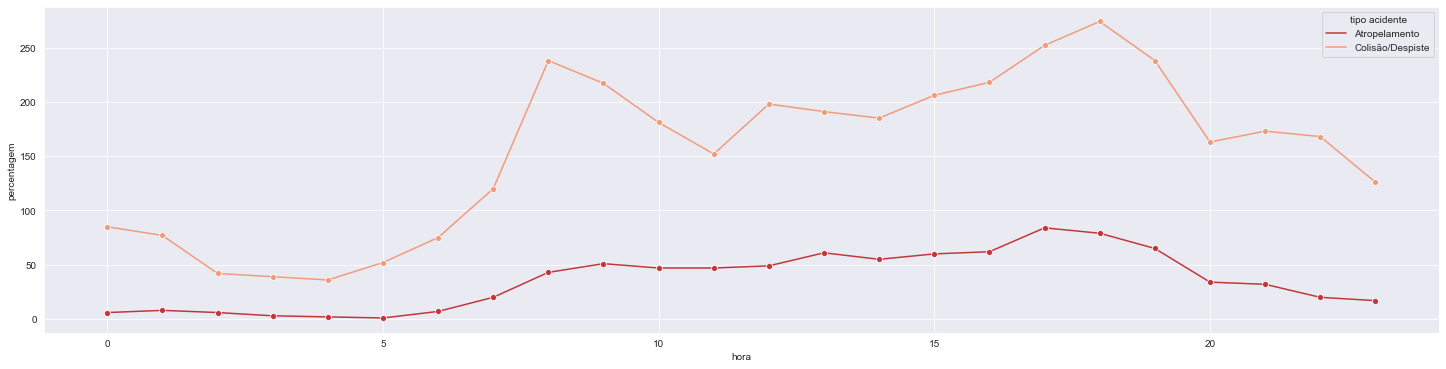

In [6]:
hour_counting = (
    data_wo_geolocation
    .groupby(['hora', 'tipo acidente'])
    .agg(percentagem = ('data', np.size))
)
plt.figure(figsize = (25, 6))
sns.lineplot(data = hour_counting, x='hora', y='percentagem', hue='tipo acidente', marker='o')

Main points:
1. Has we have seen before most of the accidents are collisions;
2. There seem to be two main peaks, one around 9 o'clock and another around 18 o'clock;
3. These times are the rush hours and so we normally have more cars moving and it makes sense that there are more accidents;
4. To have a better look at both types of accidents let's normalize the data.

<AxesSubplot:xlabel='hora', ylabel='percentagem'>

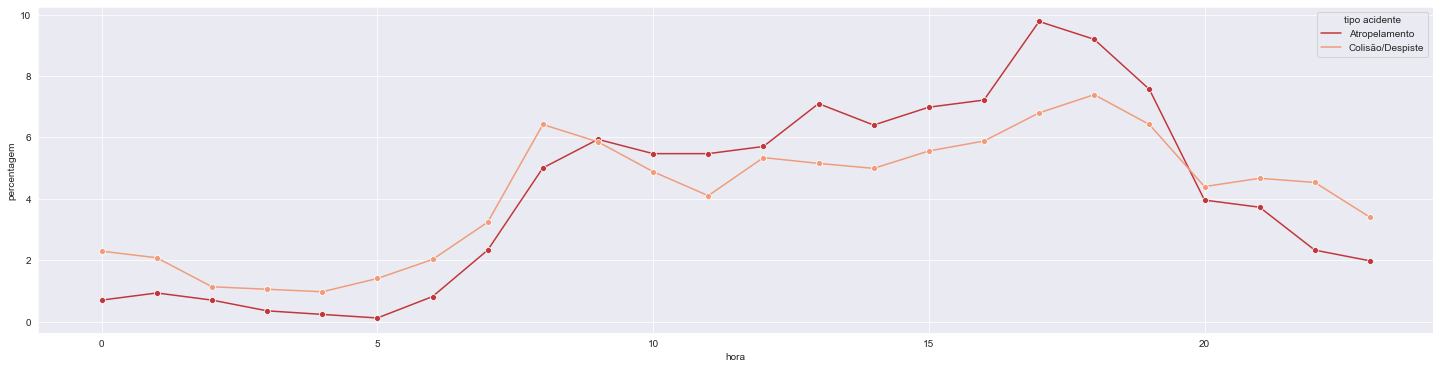

In [7]:
hour_counting = hour_counting.groupby('tipo acidente').apply(lambda x: 100 * x / float(x.sum())).reset_index()
plt.figure(figsize = (25, 6))
sns.lineplot(data = hour_counting, x='hora', y='percentagem', hue='tipo acidente', marker='o')

Main points:
1. After the normalization we can see that both types of accidents have very similar trends;
2. However, we also know that the hour of the day is probably a confounding variable and we will need to evaluate traffic levels in the city to understand the impact it has n the accidents.

### 3.3. Evaluate the day of the week

Ok now that we evaluated how the number of accidents varies over time, we have some ideas when more accidents occur. However, does this rate occurs every day of the week? Or are there some variations over the days of the week?

<AxesSubplot:xlabel='dia_semana', ylabel='percentagem'>

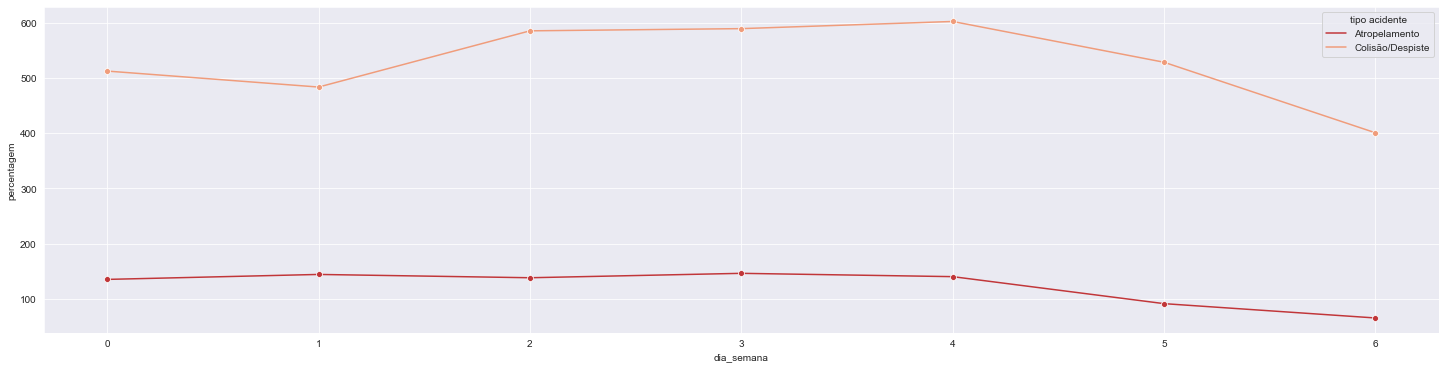

In [8]:
weekday_counting = (
    data_wo_geolocation
    .groupby(['dia_semana', 'tipo acidente'])
    .agg(percentagem = ('data', np.size))
)
plt.figure(figsize = (25, 6))
sns.lineplot(data = weekday_counting, x='dia_semana', y='percentagem', hue='tipo acidente', marker='o')

Main points:
1. Has expected the days with fewer accidents are Saturday and Sunday (5 and 6), however only slightly;
2. Monday and Tuesday also have a lower number of accidents, what could explain this?
3. Once again let's normalize the data and reevaluate the graph;

<AxesSubplot:xlabel='dia_semana', ylabel='percentagem'>

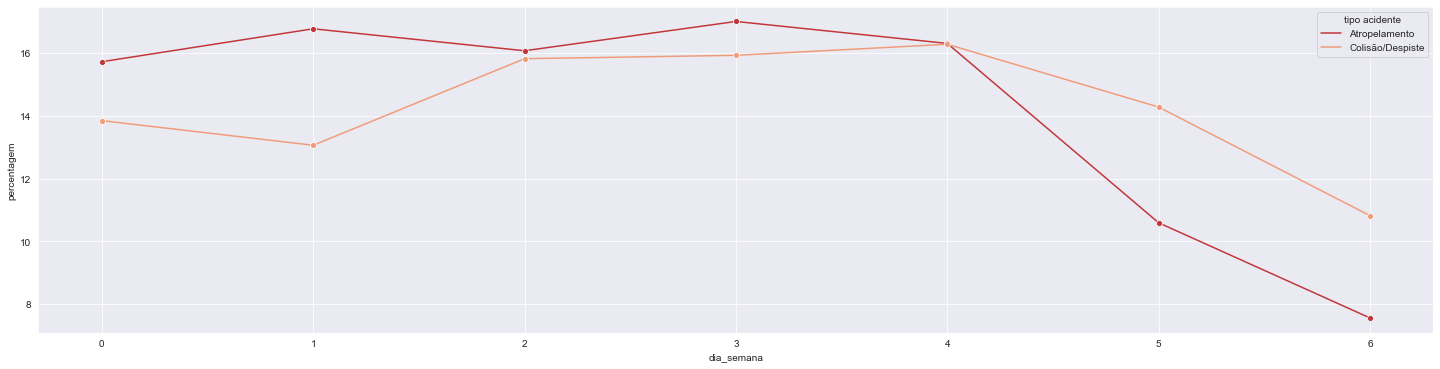

In [9]:
weekday_counting = weekday_counting.groupby('tipo acidente').apply(lambda x: 100 * x / float(x.sum())).reset_index()
plt.figure(figsize = (25, 6))
sns.lineplot(data = weekday_counting, x='dia_semana', y='percentagem', hue='tipo acidente', marker='o')

Main points:
1. It seems that the runovers have a more stable number of occurrences over the week and a big decline in the weekend. 
2. Again, is this due to the smaller number of cars that are in the city?
3. The collisions continue to have the same behavior with the lower number on Mondays and Tuesdays (0 and 1) and Sundays and Saturdays (5 and 6);

### 3.4. Evaluate the month
Another time feature we can evaluate is the number of accidents per month. Using the previous information we would expect to see a smaller number of accidents during the summer months when most of the people take vacations. at the same time, these are probably the times when most of the tourists come to visit Lisbon... Let's explore the data.

<AxesSubplot:xlabel='mes', ylabel='percentagem'>

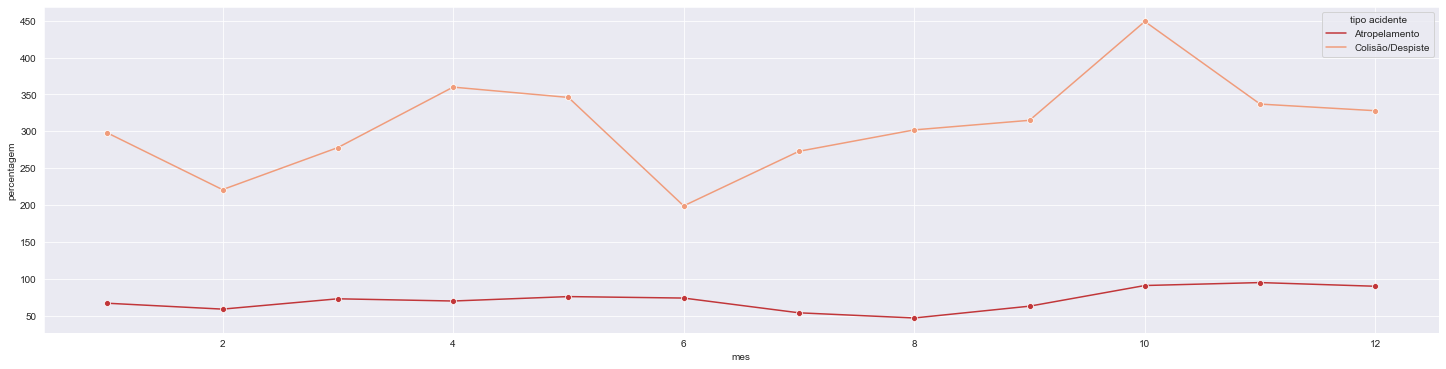

In [10]:
month_counting = data_wo_geolocation.groupby(['mes', 'tipo acidente']).agg(percentagem = ('data', np.size))
plt.figure(figsize = (25, 6))
sns.lineplot(data = month_counting, x='mes', y='percentagem', hue='tipo acidente', marker='o')

Main points:
1. The months with fewer accidents seem to be February and June. Could this be an influence on the number of days per month?
2. The month with the bigger number of accidents in November.
3. Once again we have to normalize the data to better compare the two types of accidents. However, we have to normalize the accidents per number of days and then convert to percentage;

<AxesSubplot:xlabel='mes_data', ylabel='percentagem'>

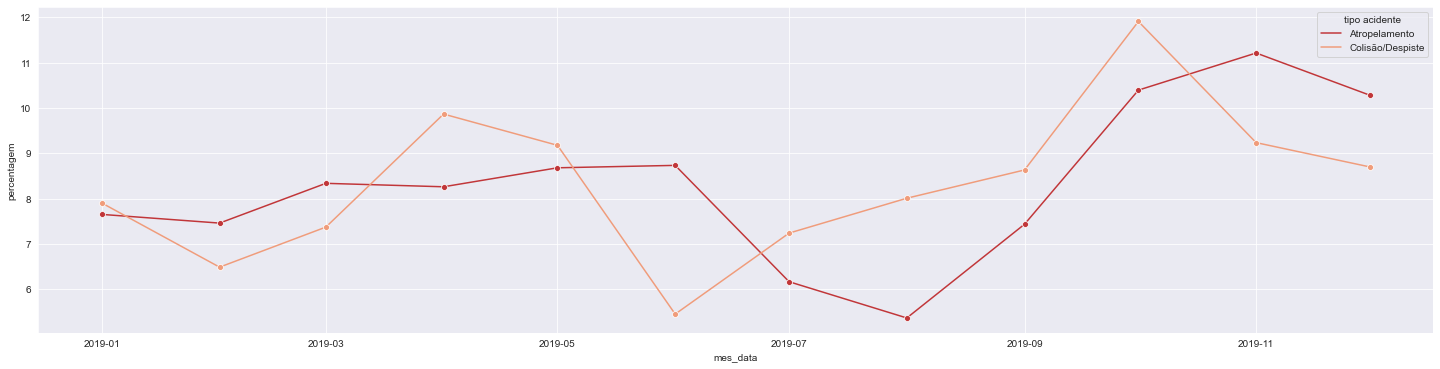

In [11]:
month_counting = (
    month_counting
    .reset_index()
    .assign(mes_data = lambda x: pd.to_datetime(x['mes'].astype(str) + '-01-2019'))
    .assign(n_dias = lambda x: x['mes_data'].dt.daysinmonth)
    .assign(percentagem = lambda x: x['percentagem'] / x['n_dias'])
    .drop(columns = ['n_dias', 'mes'])
    .set_index(['mes_data', 'tipo acidente'])
    .groupby('tipo acidente')
    .apply(lambda x: 100 * x / float(x.sum()))
    .reset_index()
)
plt.figure(figsize = (25, 6))
sns.lineplot(data = month_counting, x='mes_data', y='percentagem', hue='tipo acidente', marker='o')

Main points:
1. The month with fewer collisions, is June and the one with fewer run overs is August;
2. The month with more accidents was November, however, we can see a great increment of accidents at the end of the year;

### 3.5. Evaluate run overs through weekday and hour
We try to evaluate now the variance over the weekday and hour, to try to understand when more run-overs occur.

In [56]:
def sort_days(df, day_column):
    df[day_column] = pd.Categorical(df[day_column], ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
    df = df.sort_values(day_column)
    return df

In [57]:
final_graph_data = (
    data_wo_geolocation
    .rename(columns = {'dia_semana': 'Weekday',
                       'hora': 'Hour'})
    .replace({'Weekday': {0: 'Monday',
                          1: 'Tuesday',
                          2: 'Wednesday',
                          3: 'Thursday',
                          4: 'Friday',
                          5: 'Saturday',
                          6: 'Sunday'}})
    .pipe(sort_days, 'Weekday')
)

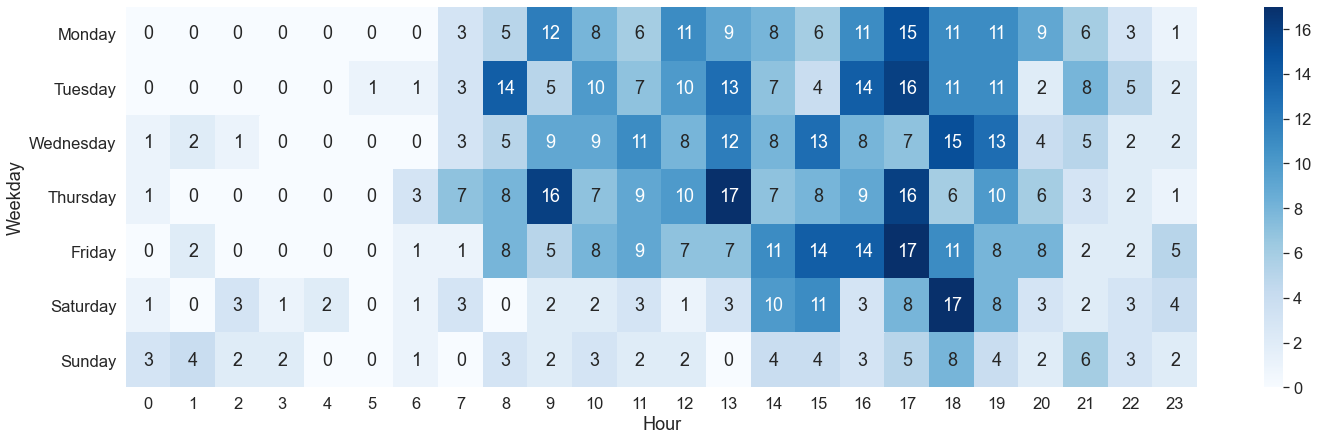

In [63]:
sns.set(font_scale=1.5)

plt.figure(figsize=(24, 7))
atropelamentos = final_graph_data.query('`tipo acidente` == "Atropelamento"')
heatmap_data = pd.pivot_table(atropelamentos, index='Weekday', columns='Hour', values='tipo acidente', aggfunc=np.size, fill_value=0)
svm = sns.heatmap(heatmap_data, annot=True, cmap="Blues")
plt.yticks(rotation=0)
plt.show()

figure = svm.get_figure()    
figure.savefig('../03-images/heatmap_run_overs_by_time.png', dpi=400)

Main points:
1. As we saw before most of the run overs happen between 8 and 19 and Mondays and Saturdays;
2. However, during Saturday most of the run overs occur at the end of the day;

### 3.6. Evaluate collisions through weekday and hour
We try to evaluate how the variance of collisions during the weekday and hour, to try to understand when more run-overs occur.

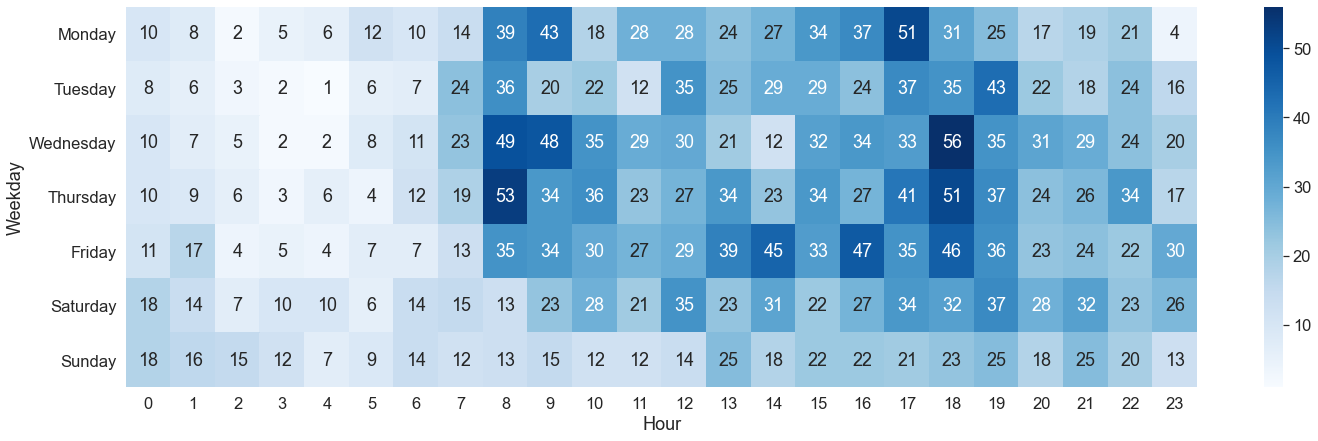

In [64]:
sns.set(font_scale=1.5)

plt.figure(figsize=(24, 7))
colisao_despiste = final_graph_data.query('`tipo acidente` == "Colisão/Despiste"')
heatmap_data = pd.pivot_table(colisao_despiste, index='Weekday', columns='Hour', values='tipo acidente', aggfunc=np.size, fill_value=0)
svm = sns.heatmap(heatmap_data, annot=True, cmap="Blues", )
plt.yticks(rotation=0)
plt.show()

figure = svm.get_figure()    
figure.savefig('../03-images/heatmap_collisions_by_time.png', dpi=400)

Main points:
1. Has we seen before the main occurrence of accidents happens during the morning and end of the afternoon periods;
2. However, in this case, there seems to be a higher incidence of collisions also during the weekend especially in the afternoon. Probably persons going out.